# Clothoid Exploration

Due to a personal project I got somewhat involved with clothoids (also known as Euler spiral or Cornu spiral). I mainly wanted to analytically determine the **distance to a point** and **get a bounding box**. The main feature of a clothoid is that is has a **linearly increasing curvature** which makes it a ideal transition between two curvatures. Basis of the clothoid are the Fresnel integrals.

\begin{equation*}
S(s) = \int_0^s sin(\frac{1}{2} \pi t^2) dt
\end{equation*}

\begin{equation*}
C(s) = \int_0^s cos(\frac{1}{2} \pi t^2) dt
\end{equation*}

In [1]:
import matplotlib.pyplot as plt
import scipy.special as sc
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

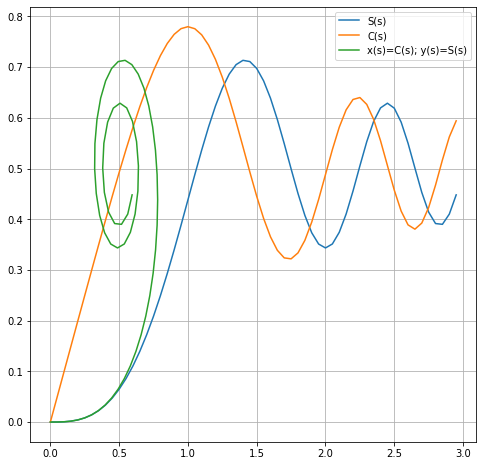

In [3]:
s_vals = np.arange(0.0, 3.0, 0.05)
S, C = sc.fresnel(s_vals)
plt.plot(s_vals, S, label="S(s)")
plt.plot(s_vals, C, label="C(s)")
plt.plot(C, S, label="x(s)=C(s); y(s)=S(s)")
plt.legend(loc="upper right")

As you can see if we use $x(s)=C(s)$ and $y(s)=C(s)$ we get the typical shape of a clothoid. There is also a constant which controls the incline in curvature (*a*). For the library I used the formula was:

\begin{equation*}
\begin{pmatrix}
x \\\
y 
\end{pmatrix}
(s) = a*\int_0^{\frac{s}{a}}
\begin{pmatrix}
cos(\frac{1}{2} \pi t^2) \\\
sin(\frac{1}{2} \pi t^2) 
\end{pmatrix} dt
\end{equation*}

\begin{equation*}
a = \sqrt{\frac{\pi}{\lvert \dot c \rvert}}
\end{equation*}

Where $\dot c$ is the derivate of curvature $c$. The curvature is in $\frac{1}{m}$ and dictates the radius a circle would have a certain point along the clothoid. Using different $\dot c$ values gives us an impresssion how this parameter affects the shape. Also we can get the tangent angle of any point on the clothoid via:

\begin{equation*}
\alpha_{tangent} = \frac{1}{2} s^2 \dot c
\end{equation*}

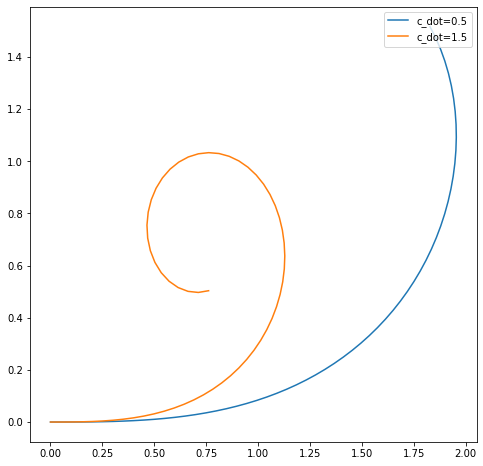

In [3]:
s_vals = np.arange(0.0, 3.0, 0.05)
a_1 = np.sqrt(np.pi/np.abs(0.5))
S_1, C_1 = sc.fresnel([s/a_1 for s in s_vals])
plt.plot([a_1*x for x in C_1], [a_1*y for y in S_1], label="c_dot=0.5")

a_2 = np.sqrt(np.pi/np.abs(1.5))
S_2, C_2 = sc.fresnel([s/a_2 for s in s_vals])
plt.plot([a_2*x for x in C_2], [a_2*y for y in S_2], label="c_dot=1.5")

plt.legend(loc="upper right")

A way to specify a clothoid curve is by giving a start ($c_{start}$) and end curvature ($c_{end}$), as well as the length. We can get the curvature derivative by $\dot c = \frac{c_{end}-c_{start}}{l}$. We get the starting arclength $s_{start}$ that corresponds to $c_{start}$ via $s_{start} = \frac{c_{start}}{\dot c}$. To have $s_{start}$ be at $(0,0)$ and have an initial slope of 0 we apply a translation and rotation on the original clothoid. The original clothoid is translated by $(-x_{start}, -y_{start})$ and then rotated by $\alpha_{start}$. This corresponds to applying a 2D affine translation, then rotation Matrix.

\begin{equation*}
\begin{pmatrix}
x_{t} \\\
y_{t} \\\
1
\end{pmatrix}
=
\begin{pmatrix}
cos(\alpha_{0}) & -sin(\alpha_{0}) & 0 \\\
sin(\alpha_{0}) & cos(\alpha_{0}) & 0 \\\
0 & 0 & 1
\end{pmatrix}
*
\begin{pmatrix}
1 & 0 & -x_{start} \\\
0 & 1 & -y_{start} \\\
0 & 0 & 1
\end{pmatrix}
*
\begin{pmatrix}
x \\\
y \\\
1
\end{pmatrix}
\end{equation*}

\begin{equation*}
x_{t}(s) = (\cos(\alpha_0) * (x(s)-x(s_{start})) - (\sin(\alpha_0) * (y(s)-y(s_{start}))
\end{equation*}

\begin{equation*}
y_{t}(s) = (\sin(\alpha_0) * (x(s)-x(s_{start})) + (\cos(\alpha_0) * (y(s)-y(s_{start})) 
\end{equation*}

\begin{equation*}
s = [s_{start}, s_{end}]
\end{equation*}

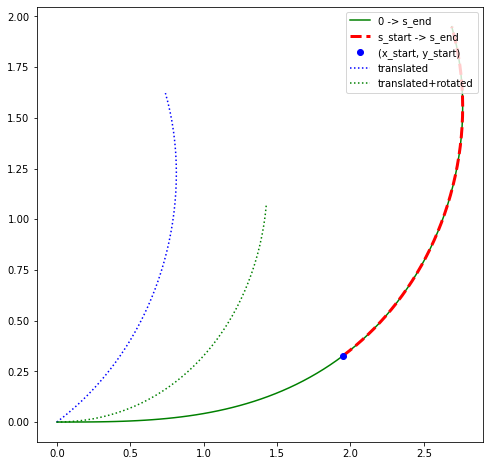

In [2]:
c_start = .5
c_end = 1
length = 2

c_dot = (c_end - c_start)/length
s_start = c_start/c_dot
s_end = c_end/c_dot

a = np.sqrt(np.pi/np.abs(c_dot))
S_1, C_1 = sc.fresnel([s/a for s in np.arange(0.0, s_end, 0.05)])
plt.plot([a*x for x in C_1], [a*y for y in S_1], 'g-', label="0 -> s_end")

s_vals = np.arange(s_start, s_end, 0.05)
S_2, C_2 = sc.fresnel([s/a for s in s_vals])
plt.plot([a*x for x in C_2], [a*y for y in S_2], 'r--', label="s_start -> s_end", linewidth=3)

f_x = lambda s : a * (sc.fresnel([s/a])[1][0])
f_y = lambda s : a * (sc.fresnel([s/a])[0][0])
plt.plot([f_x(s_start)], [f_y(s_start)], 'bo', label="(x_start, y_start)")

f_x_t = lambda s, a0 : np.cos(-a0)*(f_x(s)-f_x(s_start)) - (np.sin(-a0) * (f_y(s)-f_y(s_start)))
f_y_t = lambda s, a0 : np.sin(-a0)*(f_x(s)-f_x(s_start)) + (np.cos(-a0) * (f_y(s)-f_y(s_start)))
plt.plot([f_x_t(s, 0.0) for s in s_vals], [f_y_t(s, 0.0) for s in s_vals], 'b:', label="translated")
alpha_0 = 0.5*s_start*s_start*c_dot
plt.plot([f_x_t(s, alpha_0) for s in s_vals], [f_y_t(s, alpha_0) for s in s_vals], 'g:', label="translated+rotated")

plt.legend(loc="upper right")

Instead of specifying $x_{t}(s)$ with $s$ going from $s_{start}$ to $s_{end}$ we can also adapt the formula, so that we can input the arclength for $s$. Starting at 0 and going to length $l$.

\begin{equation*}
x_{t}(s) = (\cos(-\alpha_0) * (x(s_{start}+s)-x(s_{start})) - (\sin(-\alpha_0) * (y(s_{start}+s)-y(s_{start}))
\end{equation*}

\begin{equation*}
y_{t}(s) = (\sin(-\alpha_0) * (x(s_{start}+s)-x(s_{start})) + (\cos(-\alpha_0) * (y(s_{start}+s)-y(s_{start})) 
\end{equation*}

\begin{equation*}
s = [0, l]
\end{equation*}

## Bounding Box

Taking the above formula we know that the origin will always be at $(0,0)$. So to get a bounding box we only need to find out the **maximum x and y value**. Since the x and y values are in its core calculated from the **Fresnel integrals** we need it's derivative function. We can use it to find the derivative function of $x_{t}(s)$ and $y_{t}(s)$. As can be seen in the graph below the roots of $x_{t}'(s)$ are at extrema points of $x_{t}(s)$. We get the $s$ values of the roots of $x_{t}'(s)$ in the interval $[s_{start}, s_{end}]$ and pick the $s$ value which has the highest absolute value $|x_{t}(s)|$. Same goes for $y_{t}(s)$.

\begin{equation*}
x'(s) = sin(\frac{1}{2} s^2 \dot c) \quad y'(s) = cos(\frac{1}{2} s^2 \dot c)
\end{equation*}

\begin{equation*}
x_{t}'(s) = cos(-\alpha_{0})*cos(\frac{1}{2} s^2 \dot c) - sin(-\alpha_{0})*sin(\frac{1}{2} s^2 \dot c)
\end{equation*}

\begin{equation*}
y_{t}'(s) = sin(-\alpha_{0})*cos(\frac{1}{2} s^2 \dot c) + cos(-\alpha_{0})*sin(\frac{1}{2} s^2 \dot c)
\end{equation*}

\begin{equation*}
s = [s_{start}, s_{end}]
\end{equation*}

For $x_{t}'(s) = 0$ we find:

\begin{equation*}
s_{xmax} = \pm \frac{\sqrt{2 \alpha_{0} - 2 \pi n + \pi}}{\sqrt{\dot c}}
\end{equation*}

Note that these equations give you the result in the the range $s = [s_{start}, s_{end}]$. For the clothoids plotted here we specify s in the range $s = [0, l]$. This means we simply need to subtract $s_{start}$ if we want the result in that range.

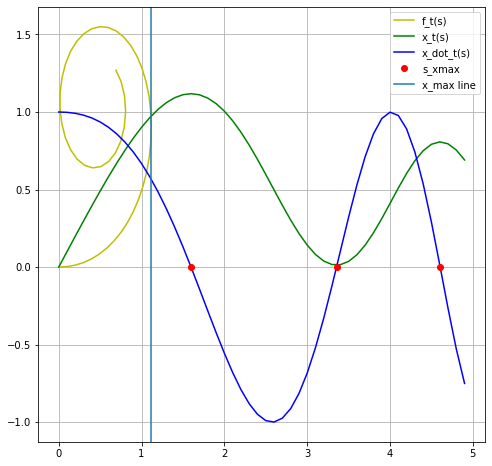

In [39]:
c_start = 0.6
c_end = 3.0
length = 5

c_dot = (c_end - c_start)/length
s_start = c_start/c_dot
s_end = c_end/c_dot
a0 = 0.5*s_start*s_start*c_dot
s_vals = np.arange(0.0, length, 0.1)
a = np.sqrt(np.pi/np.abs(c_dot))

f_x = lambda s : a * (sc.fresnel([s/a])[1][0])
f_y = lambda s : a * (sc.fresnel([s/a])[0][0])
f_x_t = lambda s : np.cos(-a0)*(f_x(s+s_start)-f_x(s_start)) - (np.sin(-a0) * (f_y(s+s_start)-f_y(s_start)))
f_y_t = lambda s : np.sin(-a0)*(f_x(s+s_start)-f_x(s_start)) + (np.cos(-a0) * (f_y(s+s_start)-f_y(s_start)))
plt.plot([f_x_t(s) for s in s_vals], [f_y_t(s) for s in s_vals], 'y-', label="f_t(s)")
plt.plot(s_vals, [f_x_t(s) for s in s_vals], 'g-', label="x_t(s)")

f_x_dot_t = lambda s : np.cos(-a0)*np.cos(0.5* (s+s_start)**2 *c_dot) - np.sin(-a0)*np.sin(0.5* (s+s_start)**2 *c_dot)
plt.plot(s_vals, [f_x_dot_t(s) for s in s_vals], 'b-', label="x_dot_t(s)")

f_s_xmax = lambda n : np.sqrt((2*a0 - 2*np.pi*n + np.pi)/c_dot) - s_start
plt.plot([f_s_xmax(0), f_s_xmax(-1), f_s_xmax(-2)], [0, 0, 0], 'ro', label="s_xmax")
plt.axvline(f_x_t(f_s_xmax(0)), 0, 1, label='x_max line')

plt.legend(loc="upper right")
plt.grid(True)

## Distance to point

We will start simple and use the basic formula for the clothoid shape:

\begin{equation*}
\begin{pmatrix}
x \\\
y 
\end{pmatrix}
(s) = \int_0^{s}
\begin{pmatrix}
cos(\frac{1}{2} \pi t^2) \\\
sin(\frac{1}{2} \pi t^2) 
\end{pmatrix} dt
\end{equation*}

To find the minimum distance from a point $(pt_{x}, pt_{y})$ to the clothoid we have to find the minimum of the distance function $f_{d}(s)$. As before we do this by finding the roots of its derivative $f_{d}'(s)$.

\begin{equation*}
f_{d}(s)=\sqrt{h(s)} \quad \quad h(s)=(f_{x}(s)-pt_{x})^2 + (f_{y}(s)-pt_{y})^2
\end{equation*}

\begin{equation*}
f_{d}'(s)=\frac{1}{2\sqrt{h(s)}} * h'(s) \quad \quad h'(s)= 2 f_{x}(s) f_{x}'(s) - 2 pt_{x} f_{x}'(s) + 2 f_{y}(s) f_{y}'(s) - 2 pt_{y} f_{y}'(s)
\end{equation*}

distance minimum at s=0.862999 f_dist'(0.862999) = -9.530505303189781e-05


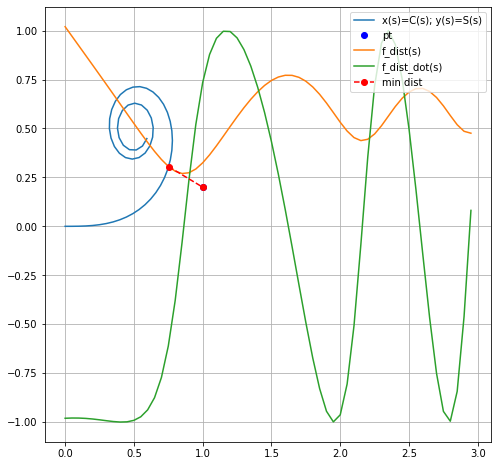

In [2]:
s_vals = np.arange(0.0, 3.0, 0.05)
S, C = sc.fresnel(s_vals)
plt.plot(C, S, label="x(s)=C(s); y(s)=S(s)")

pt_x = 1.0
pt_y = 0.2
plt.plot([pt_x], [pt_y], 'bo', label="pt")

f_x = lambda s : sc.fresnel(s)[1]
f_y = lambda s : sc.fresnel(s)[0]
f_dist = lambda s : np.sqrt((f_x(s)-pt_x)**2 + (f_y(s)-pt_y)**2)
plt.plot(s_vals, [f_dist(s) for s in s_vals], label="f_dist(s)")

f_x_dot = lambda s : np.cos(0.5*np.pi*s*s)
f_y_dot = lambda s : np.sin(0.5*np.pi*s*s)
f_dist_dot = lambda s : (1/(2*f_dist(s)))*(2*f_x(s)*f_x_dot(s) - 2*pt_x*f_x_dot(s) + 2*f_y(s)*f_y_dot(s) - 2*pt_y*f_y_dot(s))
plt.plot(s_vals, [f_dist_dot(s) for s in s_vals], label="f_dist_dot(s)")

print("distance minimum at s={} f_dist'({}) = {}".format(0.862999, 0.862999, f_dist_dot(0.862999)))
plt.plot([f_x(0.862999), pt_x], [f_y(0.862999), pt_y], 'ro--', label="min dist")

plt.legend(loc="upper right")
plt.grid(True)